# 机器学习大作业
- 小组成员：胡博浩-2212998-信息安全、蔡鸿-2212989-信息安全、张政泽-2213573-信息安全

## 基本要求
1. 复现PairPot论文中基于随机游走的Lasso-View的方法，预测并可视化展示用户感兴趣的细胞群
2. 使用论文中的方法，对结果进行评价，评价90%正常标签并模拟10%错误标签(错误率范围0-95%)

下面给出我们实现的LPA.py文件

In [ ]:
import numpy as np
from scipy import sparse
from typing import List
import random
from collections import Counter

class matCoo:
    def __init__(self, n: int = 0, m: int = 0):
        self.n = n
        self.m = m
        self.elem = []
        self.totalElements = 0

    def createMat(self, n: int, m: int):
        self.n = n
        self.m = m
        self.elem.clear()
        self.totalElements = 0

    def matTimes(self, c: float):
        if c == 0:
            self.elem.clear()
            self.totalElements = 0
        else:
            self.elem = [(row, col, val * c) for row, col, val in self.elem]

    def append(self, row: int, col: int, val: float):
        if not np.isclose(val, 0):
            self.elem.append((row, col, val))
            self.totalElements += 1

    def to_scipy_coo(self):
        if not self.elem:
            return sparse.coo_matrix(([], ([], [])), shape=(self.n, self.m))
        rows, cols, data = zip(*sorted(self.elem))
        return sparse.coo_matrix((data, (rows, cols)), shape=(self.n, self.m))

class mat:
    def __init__(self, n: int = 1, m: int = 1):
        self.n = n
        self.m = m
        self.v = np.zeros((n, m), dtype=float)

    def createMat(self, n: int, m: int):
        self.n = n
        self.m = m 
        self.v = np.zeros((n, m), dtype=float)

    def matTimes(self, c: float):
        self.v *= c

    def findDiff(self, other: 'mat') -> float:
        if self.n != other.n or self.m != other.m:
            return -1
        return np.sum(np.abs(self.v - other.v))

    def setneg(self):
        self.v.fill(-1)

    def editval(self, x: int, y: int, val: float):
        self.v[x, y] = val

    def getval(self, x: int, y: int) -> float:
        return self.v[x, y]

    def editval2(self, x: int, y: int):
        self.v[x, :] = 0
        self.v[x, y] = 1

def matMultiply(x1: matCoo, x2: mat, res: mat):
    coo_m = x1.to_scipy_coo()
    res.v = coo_m.dot(x2.v)

def calculate_neighbor_weights(sorted_elem, start_idx, end_idx, node_idx):
    """优化的邻居节点权重计算"""
    weights = []
    neighbors = []
    for j in range(start_idx, end_idx):
        neighbor_idx = sorted_elem[j][1]
        edge_weight = sorted_elem[j][2]
        weights.append((neighbor_idx, edge_weight))
        neighbors.append(neighbor_idx)
    return weights, neighbors

def weighted_label_vote(weights, y_ori, neighbor_indices):
    """改进的带权重标签投票"""
    vote_dict = {}
    for (idx, weight), neighbor_idx in zip(weights, neighbor_indices):
        if 0 <= idx < y_ori.shape[0]:  # 添加边界检查
            label = y_ori[idx, 0]
            vote_dict[label] = vote_dict.get(label, 0) + weight
    return max(vote_dict.items(), key=lambda x: x[1]) if vote_dict else (None, 0)

def dataProcess(y_old: mat, y_new: mat, preserved: float = 0.8, changed: float = 0.1, masked: float = 0.1):
    n0, m0 = y_old.n, y_old.m
    y_new.createMat(n0, m0)
    y_new.setneg()

    r = np.random.rand(n0)
    mask_preserved = r < preserved
    mask_changed = (r >= preserved) & (r < preserved + changed)
    mask_masked = r >= preserved + changed

    # 保留标签
    y_new.v[mask_preserved] = y_old.v[mask_preserved]
    # 标记缺失
    y_new.v[mask_masked] = -1

    # 随机修改标签
    changed_indices = np.where(mask_changed)[0]
    for i in changed_indices:
        if y_old.v[i, 0] != -1:
            available_labels = list(range(m0))
            current_label = np.where(y_old.v[i] == 1)[0][0]
            available_labels.remove(current_label)
            if available_labels:
                new_label = random.choice(available_labels)
                y_new.v[i] = 0
                y_new.v[i, new_label] = 1

def rectify(x: matCoo, y_label: mat, y_ori: mat, y_new: mat, base_confidence: float = 0.5):
    """改进的标签修正函数"""
    y_new.v = y_ori.v.copy()
    if not x.elem:
        return

    sorted_elem = sorted(x.elem, key=lambda e: (e[0], e[1]))

    curr_row = 0
    for i in range(y_label.n):
        if y_label.v[i, 0] == -1:
            continue

        # 找到当前节点的邻居
        while curr_row < len(sorted_elem) and sorted_elem[curr_row][0] < i:
            curr_row += 1
        start_idx = curr_row
        while curr_row < len(sorted_elem) and sorted_elem[curr_row][0] == i:
            curr_row += 1
        end_idx = curr_row

        # 获取邻居权重和索引
        neighbor_weights, neighbor_indices = calculate_neighbor_weights(
            sorted_elem, start_idx, end_idx, i)
        
        if not neighbor_weights:  # 跳过没有邻居的节点
            continue
            
        current_label = y_ori.v[i, 0]
        
        # 使用改进的投票机制
        best_label, confidence = weighted_label_vote(
            neighbor_weights, y_ori.v, neighbor_indices)

        # 动态计算置信度阈值
        num_neighbors = len(neighbor_weights)
        dynamic_confidence = base_confidence + (1 - base_confidence) * (1 - 1 / (1 + num_neighbors))

        # 根据动态置信度修改标签
        if best_label is not None and confidence > dynamic_confidence:
            if best_label != current_label:
                y_new.v[i, 0] = best_label

def labelPropagation(
    X: matCoo,
    y_label: mat, 
    y_pred: mat,
    y_res: mat,
    alpha: float = 0.3,    # 降低alpha增加稳定性
    max_iter: int = 2000,  # 增加迭代次数
    tol: float = 1e-6      # 提高收敛精度
):
    """改进的标签传播算法"""
    n_samples = X.n
    n_classes = y_label.m

    # 优化权重矩阵
    W = X.to_scipy_coo()
    # 使用改进的权重变换
    W.data = np.exp(-alpha * (W.data ** 2)) / (1 + np.exp(-alpha * (W.data ** 2)))
    
    # 添加自环
    self_loop = sparse.eye(n_samples, format='coo')
    W = W + 0.1 * self_loop
    
    # 改进的标准化
    row_sum = np.array(W.sum(axis=1)).flatten()
    row_sum[row_sum == 0] = 1e-9
    D_inv = sparse.diags(1.0 / np.sqrt(row_sum))
    P = D_inv.dot(W).dot(D_inv)  # 对称归一化

    # 初始化
    Y_init = y_label.v.copy()
    Y_new = np.zeros_like(Y_init)
    Y_history = []  # 记录历史状态
    
    # 迭代传播
    for iter_count in range(max_iter):
        Y_old = Y_new.copy()
        
        # 标签传播
        Y_new = P.dot(Y_init)
        
        # 标签平滑
        if iter_count > 0:
            Y_new = 0.8 * Y_new + 0.2 * Y_old
        
        # 归一化
        row_sums = Y_new.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1e-9
        Y_new /= row_sums
        
        # 保持已标记节点的标签
        labeled_mask = (y_label.v != -1)
        Y_new[labeled_mask] = y_label.v[labeled_mask]
        
        # 记录历史
        Y_history.append(Y_new.copy())
        if len(Y_history) > 3:
            Y_history.pop(0)
        
        # 改进的收敛检查
        diff = np.sum(np.abs(Y_new - Y_old)) / n_samples
        if diff < tol and len(Y_history) > 2:
            # 检查最近3次迭代的稳定性
            diffs = [np.sum(np.abs(Y_history[i+1] - Y_history[i])) 
                    for i in range(len(Y_history)-1)]
            if all(d < tol for d in diffs):
                break
            
        Y_init = Y_new.copy()

    # 预测标签
    y_pred.v = np.argmax(Y_new, axis=1).reshape(-1, 1)
    
    # 改进的标签修正
    rectify(X, y_label, y_pred, y_res, confidence_threshold=0.75)

### 计算不同错误率下的ARI指数值
- 基于我们实现的LPA.py文件,针对给定的单细胞数据集，我们可以运行标签传播算法来对数据集中的细胞进行数据分类并计算不同错误率下的ARI值,进而绘制对应的ARI曲线

In [14]:
import scanpy as sc
import time
import random
import numpy as np
import pandas as pd
import LPA as LPA
from sklearn.metrics.cluster import adjusted_rand_score

df = pd.DataFrame(columns=['MR', 'ARI_o', 'ARI_r', 'Time'])

start = time.time()

# Read dataset
adata = sc.read('./dataset.h5ad')
sc.pp.neighbors(adata)

mat = adata.obsp['connectivities']
coo = mat.tocoo()
rows, cols, data = coo.row, coo.col, coo.data

mat_labels = adata.obs['annotation'].values
unique_labels = np.unique(mat_labels)
val = {label: idx for idx, label in enumerate(unique_labels)}

k1 = 1.0
while True:
    for _ in range(100):
        X = LPA.matCoo(mat.shape[0], mat.shape[0])
        for i in range(len(data)):
            X.append(rows[i], cols[i], data[i])

        y_label = LPA.mat(mat.shape[0], len(val))
        y_label.setneg()

        y_new = LPA.mat(mat.shape[0], len(val))
        random_indexes = random.sample(range(mat.shape[0]), int(mat.shape[0] * 0.1))
        for i in random_indexes:
            label_idx = val[mat_labels[i]]
            y_label.editval2(i, label_idx)

        y_pred = LPA.mat(mat.shape[0], len(val))
        y_res = LPA.mat(mat.shape[0], len(val))

        start_time = time.perf_counter()
        LPA.dataProcess(y_label, y_new, k1, (1 - k1), 0)
        LPA.labelPropagation(X, y_new, y_pred, y_res, 0.5, 1000)
        end_time = time.perf_counter()
        execution_time = end_time - start_time

        res_arr = np.zeros(mat.shape[0])
        for i in range(mat.shape[0]):
            res_arr[i] = y_pred.getval(i, 0)
        ari_o = adjusted_rand_score(mat_labels, res_arr)

        res_arr2 = np.zeros(mat.shape[0])
        for i in range(mat.shape[0]):
            res_arr2[i] = y_res.getval(i, 0)
        ari_r = adjusted_rand_score(mat_labels, res_arr2)

        item = [round((1 - k1), 2), ari_o, ari_r, round(execution_time, 5)]
        print(item)
        df.loc[len(df)] = item

    k1 -= 0.05
    print(k1)
    if k1 < 0:
        break

df.to_csv("mistake.tsv", sep='\t', header=True, index=True)

end = time.time()
print("time: {}".format(end - start))

C:\Users\20605\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\20605\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_utils.py:41: UserWarning: You’re trying to run this on 2000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


[0.0, 0.7828208716140685, 0.7774156660270078, 0.24568]
[0.0, 0.7671579980275747, 0.7615420580358119, 0.26831]
[0.0, 0.7950678736727043, 0.7920772756065093, 0.29362]
[0.0, 0.8202317389169057, 0.8174612679583935, 0.22111]
[0.0, 0.8482606238129312, 0.8456467271126634, 0.33051]
[0.0, 0.8381425207188185, 0.8318243586590102, 0.26372]
[0.0, 0.8332512189821248, 0.8288670222185959, 1.46588]
[0.0, 0.7990400365593167, 0.7949491448122175, 0.39482]
[0.0, 0.7890154734807603, 0.7836493965413458, 0.31376]
[0.0, 0.8537407373359107, 0.8482049252553262, 0.33672]
[0.0, 0.8295372739013056, 0.8240909798806885, 0.26676]
[0.0, 0.8174302946046235, 0.8161924591371852, 0.31193]
[0.0, 0.857271565109909, 0.8542048650173175, 0.37159]
[0.0, 0.8039220568742708, 0.801244473990629, 0.27516]
[0.0, 0.8257364644515809, 0.8216080867686169, 0.33233]
[0.0, 0.7796855146501617, 0.775130924620681, 0.33435]
[0.0, 0.8261786189186803, 0.8221412630861763, 0.24801]
[0.0, 0.8130633114106629, 0.8075314558062964, 0.30865]
[0.0, 0.84161

### 可视化ARI曲线

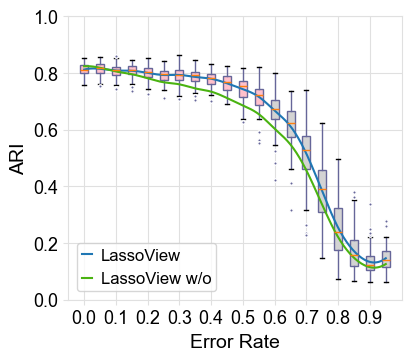

In [18]:
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.size"] = 14


df = pd.read_csv("./mistake.tsv", sep='\t', index_col=0)
mistakes = pd.DataFrame()
mistakes_wo = pd.DataFrame()
groups = df.groupby('MR')
for group in groups:
    mistakes[group[0]] = group[1]['ARI_r'].reset_index(drop=True)
    mistakes_wo[group[0]] = group[1]['ARI_o'].reset_index(drop=True)
x = np.arange(len(mistakes.columns))+1
y = list(mistakes.mean(axis=0))
y_wo = list(mistakes_wo.mean(axis=0))
x_smooth = np.linspace(x.min(), x.max(), 200)
y_smooth = make_interp_spline(x, y)(x_smooth)
y_smooth_wo = make_interp_spline(x, y_wo)(x_smooth)
fig, ax = plt.subplots(figsize=(4,3.5), constrained_layout=True)
bp = ax.boxplot(mistakes, sym='.', patch_artist=True)
plt.setp(bp['whiskers'], color='#666699')
plt.setp(bp['fliers'], markerfacecolor='#666699', markeredgecolor='white', marker='.', markersize=5)
colors = ['pink' if s > 0.7 else 'lightgrey' for s in y]
for bplot in [bp]:
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('#666699')
l=ax.plot(x_smooth, y_smooth, label="LassoView")
l_wo=ax.plot(x_smooth, y_smooth_wo, label="LassoView w/o",c='#4ab311')
ax.set_yticks(np.arange(0,11,2)*0.1)
ax.set_yticklabels(["{:.1f}".format(s) for s in np.arange(0,11,2)*0.1], fontsize=13)
ax.set_xticklabels(list(mistakes.columns), fontsize=13)
ax.set_xticks(range(-1,20,2))
ax.set_xlim(0,21)
ax.set_ylim(0,1)
ax.set_xlabel("Error Rate")
ax.set_ylabel("ARI")
ax.legend(fontsize=12, handletextpad=0.5, loc="lower left",
              borderpad=0.3,
              columnspacing=1.3,
              handlelength=0.65,)
ax.yaxis.grid(True, color='#e0e0e0')
ax.xaxis.grid(True, color='#e0e0e0')
ax.spines['top'].set_edgecolor('#e0e0e0')  # 设置上边坐标轴颜色
ax.spines['bottom'].set_edgecolor('#e0e0e0')  # 设置下边坐标轴颜色
ax.spines['left'].set_edgecolor('#e0e0e0')  # 设置左边坐标轴颜色
ax.spines['right'].set_edgecolor('#e0e0e0')
ax.tick_params(axis='both', color='#e0e0e0')
plt.savefig("mistake.svg")


### 预测用户感兴趣的细胞群

In [40]:
import numpy as np
import pandas as pd
import random
import h5py
import scipy.sparse
import LPA
import ast
import os
from pathlib import Path

def extract_sparse_matrix(filepath):
    """从h5文件提取稀疏矩阵数据"""
    with h5py.File(filepath, 'r') as store:
        # 检查是否存在 'connectivities' 对象
        if 'obsp/connectivities' in store:
            connections = store['obsp/connectivities']
        elif 'obsp/connectivity_matrix' in store:
            connections = store['obsp/connectivity_matrix']
        else:
            raise KeyError("Connectivity matrix not found in the HDF5 file.")
        
        vals = connections['data'][:]
        cols = connections['indices'][:]
        rows = connections['indptr'][:]
        dims = (connections.attrs['shape'][0], connections.attrs['shape'][1])
    return vals, cols, rows, dims

def extract_labels(filepath):
    """提取标签数据"""
    with h5py.File(filepath, 'r') as store:
        obs = store['obs']
        label_key = next(key for key in ['annotation', 'leiden-1'] if key in obs)
        data = obs[label_key]
        return data['codes'][:] if 'codes' in data else data[:]

def generate_label_mapping(labels):
    """生成标签映射"""
    unique_vals = np.unique(labels)
    mapping = dict(zip(unique_vals, range(len(unique_vals))))
    mapping[max(mapping.values()) + 1] = max(mapping.values()) + 1
    return mapping

def construct_sparse_matrix(vals, cols, rows, dims):
    """构建稀疏矩阵"""
    return scipy.sparse.csr_matrix((vals, cols, rows), shape=dims)

def convert_to_lpa_format(sparse_mat, n_samples):
    """转换为LPA格式矩阵"""
    coo = sparse_mat.tocoo()
    lpa_mat = LPA.matCoo(n_samples, n_samples)
    for r, c, v in zip(coo.row, coo.col, coo.data):
        lpa_mat.append(r, c, v)
    return lpa_mat

def initialize_label_matrix(n_samples, n_classes):
    """初始化标签矩阵"""
    label_mat = LPA.mat(n_samples, n_classes)
    label_mat.setneg()
    return label_mat

def get_training_mask(n_samples, marked_indices, train_ratio=0.1):
    """生成训练掩码"""
    mask = np.zeros(n_samples, dtype=bool)
    random_indices = random.sample(range(n_samples), int(n_samples * train_ratio))
    mask[random_indices] = True
    mask[marked_indices] = True
    return mask

def prepare_label_data(labels, marked_indices, mapping):
    """准备标签数据"""
    target_class = max(mapping.values())
    modified_labels = labels.copy()
    modified_labels[marked_indices] = target_class
    return pd.Categorical(modified_labels), target_class

def perform_label_propagation(feature_mat, init_labels, n_samples, n_classes, alpha=0.5, max_iter=1000):
    """执行标签传播"""
    pred = LPA.mat(n_samples, n_classes)
    new_labels = LPA.mat(n_samples, n_classes)
    LPA.labelPropagation(feature_mat, init_labels, pred, new_labels, alpha, max_iter)
    return new_labels

def extract_predictions(label_matrix, n_samples, target_class, marked_indices):
    """提取预测结果,确保包含已标记索引"""
    predictions = np.array([label_matrix.getval(i, 0) for i in range(n_samples)])
    predicted = set(np.where(predictions == target_class)[0])
    predicted.update(marked_indices)
    return sorted(list(predicted))

def process_dataset(input_path, output_path, data_path):
    """处理单个数据集"""
    try:
        print(input_path)
        print(output_path)
        print(data_path)
        # 读取标记索引
        with open(input_path, 'r') as f:
            marked_indices = ast.literal_eval(f.readline().strip())

        # 加载数据
        matrix_data = extract_sparse_matrix(data_path)
        sparse_matrix = construct_sparse_matrix(*matrix_data)
        labels = extract_labels(data_path)
        label_mapping = generate_label_mapping(labels)

        # 准备数据
        n_samples = labels.shape[0]
        feature_matrix = convert_to_lpa_format(sparse_matrix, n_samples)
        label_matrix = initialize_label_matrix(n_samples, len(label_mapping))
        
        # 设置训练数据
        mask = get_training_mask(n_samples, marked_indices)
        cat_labels, target_class = prepare_label_data(labels, marked_indices, label_mapping)
        
        # 更新标签矩阵
        for idx in np.where(mask)[0]:
            label_matrix.editval2(idx, label_mapping[cat_labels[idx]])

        # 执行预测
        final_labels = perform_label_propagation(
            feature_matrix, 
            label_matrix, 
            n_samples, 
            len(label_mapping)
        )
        
        # 保存结果
        predicted_indices = extract_predictions(final_labels, n_samples, target_class, marked_indices)
        with open(output_path, 'w') as f:
            f.write(str(predicted_indices))

        print(f"结果已保存至 {output_path}")
    except Exception as e:
        print(f"处理文件 {input_path} 时出错: {str(e)}")

def main():
    """主函数"""
    base_path = Path("")
    data_dir = base_path
    
    # 输出目录
    result_dir = Path("./result")
    result_dir.mkdir(parents=True, exist_ok=True)

    # 处理所有测试文件
    dataset_path = Path("./dataset1.h5ad")
    for i in range(10):
        input_file = Path(f"./test/{i}.txt")
        output_file = Path(f"./result/predict_{i}.txt")
        
        if not input_file.exists():
            print(f"找不到输入文件: {input_file}")
            continue
            
        print(f"正在处理文件 {i}")
        process_dataset(input_file, output_file, dataset_path)
    
    print("所有文件处理完成")

if __name__ == "__main__":
    main()

正在处理文件 0
test\0.txt
result\predict_0.txt
dataset1.h5ad
结果已保存至 result\predict_0.txt
正在处理文件 1
test\1.txt
result\predict_1.txt
dataset1.h5ad
结果已保存至 result\predict_1.txt
正在处理文件 2
test\2.txt
result\predict_2.txt
dataset1.h5ad
结果已保存至 result\predict_2.txt
正在处理文件 3
test\3.txt
result\predict_3.txt
dataset1.h5ad
结果已保存至 result\predict_3.txt
正在处理文件 4
test\4.txt
result\predict_4.txt
dataset1.h5ad
结果已保存至 result\predict_4.txt
正在处理文件 5
test\5.txt
result\predict_5.txt
dataset1.h5ad
结果已保存至 result\predict_5.txt
正在处理文件 6
test\6.txt
result\predict_6.txt
dataset1.h5ad
结果已保存至 result\predict_6.txt
正在处理文件 7
test\7.txt
result\predict_7.txt
dataset1.h5ad
结果已保存至 result\predict_7.txt
正在处理文件 8
test\8.txt
result\predict_8.txt
dataset1.h5ad
结果已保存至 result\predict_8.txt
正在处理文件 9
test\9.txt
result\predict_9.txt
dataset1.h5ad
结果已保存至 result\predict_9.txt
所有文件处理完成


### 可视化预测结果
- 在这里我们只使用给定的测试文件中的3.txt中的数据来进行可视化展示作为例子

C:\Users\20605\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


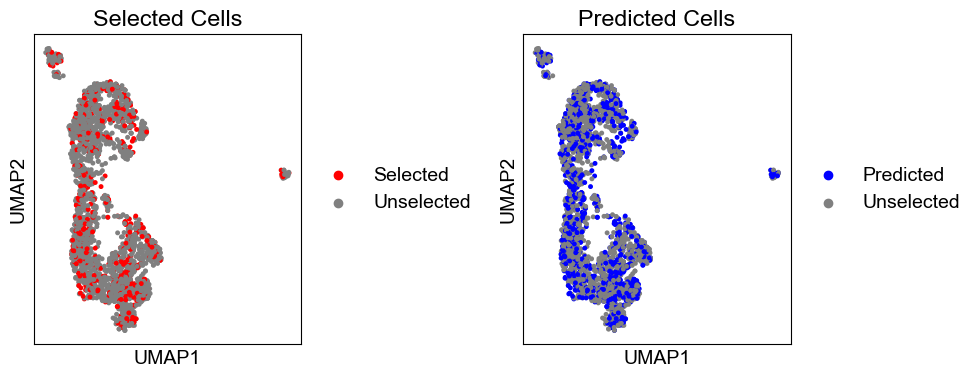

In [28]:
import scanpy as sc
import matplotlib.pyplot as plt

def load_and_prepare_data(file_path):
    """加载数据并确保索引正确"""
    data = sc.read_h5ad(file_path)
    data.obs_names_make_unique()
    data.obs.index = range(len(data.obs))
    return data

def mark_cells(data, indices, column_name, selected_label='Selected', unselected_label='Unselected'):
    """标记特定细胞"""
    data.obs[column_name] = unselected_label
    data.obs.loc[indices, column_name] = selected_label

def plot_umap(data, color_column, palette, title, size=50, ax=None):
    """绘制UMAP图"""
    sc.pl.umap(data, color=color_column, palette=palette, size=size, title=title, show=False, ax=ax)

def visualize_selected_and_predicted_cells(data, selected_indices, predicted_indices, output_file):
    """可视化选择的细胞和预测的细胞"""
    # 标记选择的细胞
    mark_cells(data, selected_indices, 'original_selection', 'Selected', 'Unselected')
    
    # 标记预测的细胞
    mark_cells(data, predicted_indices, 'prediction', 'Predicted', 'Unselected')
    
    # 创建包含两个子图的图形
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    # 绘制原始选择的细胞
    plot_umap(data, 'original_selection', {'Unselected': 'grey', 'Selected': 'red'}, 'Selected Cells', ax=ax1)
    
    # 绘制预测的细胞
    plot_umap(data, 'prediction', {'Unselected': 'grey', 'Predicted': 'blue'}, 'Predicted Cells', ax=ax2)
    
    # 调整布局
    plt.tight_layout()
    
    # 保存图片
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()

# 主函数
def main():
    # 定义数据路径
    data_path = './dataset.h5ad'
    
    # 加载数据
    adata = load_and_prepare_data(data_path)
    
    # 定义选择的细胞和预测的细胞索引
    selected_cells = [7,10,25,37,47,61,72,81,93,103,107,119,120,126,127,144,171,200,213,220,251,254,257,258,260,271,275,276,282,293,305,308,309,312,346,376,378,379,425,427,437,438,452,460,469,494,497,501,516,535,538,540,559,563,578,584,595,601,605,614,632,637,650,652,656,661,662,665,685,707,711,730,733,738,742,743,772,773,775,776,778,784,804,810,812,839,840,851,854,860,868,869,884,896,905,908,912,920,921,941,949,965,967,970,971,978,981,1003,1013,1028,1047,1049,1052,1060,1077,1083,1087,1089,1092,1112,1113,1121,1125,1136,1148,1151,1162,1163,1165,1173,1181,1182,1192,1204,1208,1216,1217,1241,1258,1263,1268,1282,1294,1322,1336,1338,1341,1349,1350,1361,1364,1371,1372,1382,1384,1394,1407,1410,1417,1421,1436,1441,1464,1467,1473,1474,1475,1490,1509,1515,1517,1520,1527,1545,1546,1549,1567,1578,1581,1584,1587,1595,1603,1606,1607,1617,1619,1620,1621,1627,1630,1637,1642,1656,1672,1673,1678,1679,1680,1689,1710,1718,1728,1732,1733,1739,1751,1765,1769,1773,1781,1790,1801,1804,1816,1822,1828,1830,1835,1840,1850,1856,1858,1898,1911,1924,1937,1947,1948,1949,1961,1966,1970,1972,1973,1974,1975,1981,1983,1994,1997,2000,2001,2010,2014,2022,2023,2034,2046,2057,2064,2070,2075,2080,2085,2106,2133,2145,2150,2155,2174,2185,2189,2195,2196,2207,2213,2226,2229,2231,2249,2253,2255,2256,2271,2273,2277,2283,2285,2286,2290,2291,2295,2303,2312,2313,2317,2320,2323,2325,2327,2347,2351,2366,2376,2377,2384,2395,2397,2401,2403,2405,2406,2417,2421,2429,2441,2456,2464,2469,2472,2481,2483,2489,2497,2500,2503,2504,2521,2522,2525,2535,2539,2544,2548,2553,2556,2571,2575,2582,2583,2591,2615,2616,2617,2621,2623,2626,2629,2641,2648,2660,2661,2674,2676,2682,2688,2694,2696,2703,2705,2716,2721,2724,2727,2732,2734,2740,2743,2752,2761,2762,2765,2766,2776,2798,2802,2822,2828,2834,2838,2849,2870,2881,2888,2893,2911,2916,2917,2925,2926,2931,2936,2937,2942,2950,2951,2954,2961,2972,2976,2978,2981,2997,612,902,0,3,12,98,114,128,147,151,185,218,219,228,234,236,240,241,287,295,304,318,364,409,443,445,453,480,519,525,536,562,572,627,647,676,694,698,705,724,749,779,783,787,811,892,893,894,904,917,930,974,979,983,986,999,1004,1031,1038,1078,1081,1090,1100,1130,1168,1180,1185,1194,1197,1248,1256,1278,1326,1333,1340,1346,1347,1356,1365,1373,1389,1409,1429,1448,1449,1453,1476,1477,1479,1514,1565,1583,1616,1625,1632,1670,1676,1686,1702,1724,1741,1748,1749,1796,1823,1827,1839,1848,1854,1903,1906,1952,1969,1978,1986,1999,2005,2019,2021,2024,2084,2098,2099,2100,2190,2205,2216,2239,2247,2262,2294,2304,2322,2332,2336,2355,2413,2446,2448,2467,2478,2488,2491,2530,2536,2538,2545,2546,2560,2563,2665,2672,2698,2702,2777,2779,2788,2793,2801,2807,2812,2824,2825,2839,2840,2865,2878,2909,2924]

    predicted_cells = [0,3,4,6,7,8,10,12,14,17,18,25,26,29,32,37,39,43,44,47,48,52,58,59,61,71,72,81,83,84,87,91,92,93,95,97,98,99,103,107,114,119,120,123,125,126,127,128,132,142,143,144,147,149,150,151,152,153,159,164,168,171,176,177,179,185,190,200,201,202,211,213,215,218,219,220,226,228,230,232,234,236,237,240,241,243,244,251,254,257,258,260,264,271,275,276,277,282,283,287,293,295,300,301,302,304,305,306,308,309,310,312,314,316,318,320,327,333,336,343,345,346,347,348,354,359,364,366,367,375,376,378,379,382,387,393,408,409,423,425,426,427,435,436,437,438,443,445,447,448,452,453,455,457,460,461,469,470,473,474,476,479,480,491,493,494,497,501,505,511,515,516,519,525,533,534,535,536,538,539,540,544,549,551,555,559,562,563,565,567,571,572,577,578,580,584,595,596,597,599,601,605,606,612,614,618,622,624,627,629,631,632,637,644,645,646,647,650,652,656,660,661,662,664,665,671,676,680,681,683,685,686,687,689,693,694,695,698,702,705,707,711,718,724,730,733,734,737,738,742,743,749,750,765,766,772,773,774,775,776,778,779,780,782,783,784,787,791,795,804,809,810,811,812,827,828,829,831,832,836,839,840,841,842,843,851,854,856,858,859,860,863,867,868,869,881,884,885,888,890,892,893,894,895,896,899,900,902,904,905,907,908,912,915,917,919,920,921,927,930,934,941,942,948,949,954,957,965,967,969,970,971,974,978,979,980,981,983,986,990,994,999,1003,1004,1013,1014,1015,1026,1028,1029,1031,1033,1037,1038,1042,1047,1049,1051,1052,1055,1057,1058,1060,1070,1077,1078,1079,1080,1081,1083,1087,1089,1090,1092,1093,1094,1099,1100,1112,1113,1118,1121,1123,1124,1125,1130,1133,1136,1144,1148,1150,1151,1152,1154,1162,1163,1165,1166,1167,1168,1173,1174,1175,1178,1180,1181,1182,1185,1192,1194,1195,1197,1204,1207,1208,1213,1214,1216,1217,1231,1239,1241,1242,1248,1256,1258,1261,1263,1268,1272,1274,1276,1278,1279,1282,1285,1286,1288,1294,1295,1304,1305,1306,1309,1310,1321,1322,1323,1325,1326,1333,1334,1336,1338,1340,1341,1342,1344,1346,1347,1349,1350,1356,1361,1364,1365,1367,1371,1372,1373,1376,1382,1383,1384,1387,1389,1390,1393,1394,1397,1400,1401,1407,1409,1410,1416,1417,1419,1421,1424,1428,1429,1434,1435,1436,1441,1445,1446,1448,1449,1452,1453,1455,1457,1458,1459,1464,1467,1470,1473,1474,1475,1476,1477,1479,1483,1488,1489,1490,1497,1500,1501,1507,1509,1512,1514,1515,1517,1520,1527,1529,1545,1546,1547,1548,1549,1552,1557,1565,1567,1578,1579,1581,1583,1584,1586,1587,1590,1595,1599,1603,1606,1607,1610,1614,1616,1617,1619,1620,1621,1625,1627,1630,1632,1637,1642,1647,1656,1661,1668,1670,1672,1673,1676,1678,1679,1680,1681,1686,1688,1689,1702,1710,1718,1721,1724,1728,1729,1732,1733,1736,1739,1741,1748,1749,1751,1757,1765,1769,1770,1773,1776,1777,1779,1780,1781,1782,1790,1796,1799,1800,1801,1804,1805,1806,1807,1809,1816,1817,1822,1823,1827,1828,1830,1832,1834,1835,1838,1839,1840,1841,1842,1846,1848,1850,1851,1854,1856,1858,1860,1865,1873,1876,1882,1887,1890,1897,1898,1899,1903,1906,1909,1911,1915,1924,1926,1928,1936,1937,1942,1944,1945,1947,1948,1949,1952,1954,1961,1966,1968,1969,1970,1972,1973,1974,1975,1976,1977,1978,1981,1982,1983,1984,1986,1994,1995,1997,1999,2000,2001,2005,2008,2009,2010,2013,2014,2019,2021,2022,2023,2024,2031,2032,2034,2038,2039,2043,2045,2046,2051,2056,2057,2061,2062,2064,2070,2075,2078,2079,2080,2084,2085,2096,2098,2099,2100,2102,2103,2106,2111,2113,2117,2121,2122,2126,2129,2132,2133,2145,2150,2155,2158,2162,2163,2167,2170,2171,2173,2174,2178,2185,2187,2188,2189,2190,2195,2196,2205,2207,2211,2213,2216,2223,2226,2229,2230,2231,2239,2241,2247,2249,2252,2253,2255,2256,2259,2262,2263,2266,2271,2273,2275,2277,2280,2283,2285,2286,2290,2291,2294,2295,2301,2303,2304,2306,2309,2310,2311,2312,2313,2317,2318,2320,2322,2323,2325,2326,2327,2329,2330,2332,2336,2338,2342,2347,2350,2351,2352,2355,2366,2368,2369,2371,2373,2375,2376,2377,2384,2387,2395,2396,2397,2399,2401,2403,2405,2406,2407,2413,2414,2417,2418,2421,2427,2428,2429,2431,2435,2439,2441,2446,2448,2452,2453,2456,2460,2462,2463,2464,2467,2469,2472,2478,2481,2482,2483,2485,2486,2488,2489,2491,2494,2497,2500,2501,2502,2503,2504,2508,2512,2521,2522,2525,2526,2527,2529,2530,2532,2533,2535,2536,2538,2539,2540,2542,2544,2545,2546,2548,2553,2556,2557,2560,2562,2563,2566,2570,2571,2572,2573,2575,2578,2579,2582,2583,2591,2592,2601,2606,2613,2614,2615,2616,2617,2619,2621,2622,2623,2626,2629,2631,2637,2640,2641,2642,2646,2647,2648,2651,2656,2658,2660,2661,2664,2665,2669,2671,2672,2674,2676,2682,2684,2688,2694,2696,2697,2698,2701,2702,2703,2705,2707,2712,2713,2714,2716,2717,2721,2723,2724,2727,2731,2732,2734,2740,2743,2744,2748,2752,2754,2758,2761,2762,2763,2765,2766,2769,2776,2777,2779,2781,2782,2784,2786,2788,2790,2791,2793,2796,2798,2801,2802,2805,2807,2811,2812,2822,2824,2825,2828,2830,2831,2834,2835,2836,2838,2839,2840,2842,2845,2847,2849,2851,2855,2856,2863,2865,2866,2869,2870,2876,2878,2880,2881,2884,2888,2893,2901,2904,2909,2911,2916,2917,2918,2919,2923,2924,2925,2926,2928,2930,2931,2935,2936,2937,2942,2943,2945,2947,2948,2949,2950,2951,2954,2961,2962,2963,2964,2966,2967,2972,2976,2978,2981,2986,2989,2997]
    
    # 可视化选择的细胞和预测的细胞
    visualize_selected_and_predicted_cells(adata, selected_cells, predicted_cells, 'Lasso-view.png')

if __name__ == "__main__":
    main()

## 进阶要求
    使用其他算法实现对数据集细胞的分类,针对这一思路，我们从两方面展开了探究，首先是尝试通过使用多个分类器结合的方式来对数据集中的细胞进行分类

### 使用多个分类器结合的方式对数据集中的细胞进行分类

In [24]:
import time
import numpy as np
import pandas as pd
import scanpy as sc
import magic
from scipy import sparse
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import adjusted_rand_score

def rectify(graph: sparse.csr_matrix, labeled_mask, corrected_labels, final_proba, dynamic_threshold=0.7):
    """
    动态阈值标签修正
    """
    data = graph.data
    indices = graph.indices
    indptr = graph.indptr
    n_samples = graph.shape[0]

    # 计算节点置信度分位数作为修正阈值(如30%)
    threshold = np.percentile(np.max(final_proba, axis=1), dynamic_threshold * 100)

    for i in range(n_samples):
        if labeled_mask[i]:
            if np.max(final_proba[i]) < threshold:
                start, end = indptr[i], indptr[i + 1]
                neighbor_indices = indices[start:end]
                neighbor_weights = data[start:end]
                vote_dict = {}
                for nid, w in zip(neighbor_indices, neighbor_weights):
                    label = corrected_labels[nid]
                    if label >= 0:
                        vote_dict[label] = vote_dict.get(label, 0) + w
                if vote_dict:
                    best_label = max(vote_dict, key=vote_dict.get)
                    corrected_labels[i] = best_label
    return corrected_labels

def label_propagation(graph: sparse.csr_matrix,
                      init_labels: np.ndarray,
                      confidence_scores: np.ndarray,
                      n_classes: int,
                      alpha: float = 0.2,
                      max_iter: int = 2000,
                      tol: float = 1e-6):
    """
    借鉴LPA.py的改进标签传播
    """
    n_samples = graph.shape[0]
    W = graph.tocoo().copy()
    W.data = np.exp(-alpha * (W.data ** 2))
    row_sum = np.array(W.sum(axis=1)).flatten()
    row_sum[row_sum == 0] = 1e-9
    D_inv = sparse.diags(1.0 / row_sum)
    P = D_inv.dot(W)

    # 初始化
    Y_init = np.zeros((n_samples, n_classes), dtype=float)
    mask_labeled = (init_labels != -1)
    for i in range(n_samples):
        if mask_labeled[i]:
            Y_init[i, init_labels[i]] = 1.0

    Y_prop = Y_init.copy()
    for _ in range(max_iter):
        Y_old = Y_prop.copy()
        Y_prop = P.dot(Y_prop)
        row_sums = Y_prop.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1e-9
        Y_prop /= row_sums
        Y_prop[mask_labeled] = Y_init[mask_labeled]
        diff = np.sum(np.abs(Y_prop - Y_old)) / n_samples
        if diff < tol:
            break
    return Y_prop

class EnhancedLPA:
    def __init__(self, n_neighbors=15, resolution=0.5):
        self.n_neighbors = n_neighbors
        self.resolution = resolution
        # 集成分类器
        self.classifiers = {
            'svm': SVC(probability=True, kernel='rbf', C=2.0),
            'rf': RandomForestClassifier(n_estimators=300, max_depth=15),
            'gb': GradientBoostingClassifier(n_estimators=150,learning_rate=0.05)
        }
        self.label_encoder = LabelEncoder()
        self.n_classes = None
        self.confidence_threshold = 0.5

    def build_adaptive_graph(self, adata):
        print("Building adaptive graph...")
        normalized_data = StandardScaler().fit_transform(adata.X)
        cosine_sim = normalized_data @ normalized_data.T
        norms = np.linalg.norm(normalized_data, axis=1)
        norms[norms == 0] = 1e-10
        cosine_sim /= np.outer(no0.8763rms, norms)
        distances = np.zeros((adata.n_obs, self.n_neighbors))
        indices = np.zeros((adata.n_obs, self.n_neighbors), dtype=int)
        for i in range(adata.n_obs):
            dist_i = 1 - cosine_sim[i]
            idx = np.argsort(dist_i)[:self.n_neighbors]
            distances[i] = dist_i[idx]
            indices[i] = idx
        sigma = np.mean(distances, axis=1)
        weights = np.exp(-distances**2 / (2 * sigma[:, np.newaxis]**2))
        rows = np.repeat(np.arange(adata.n_obs), self.n_neighbors)
        cols = indices.flatten()
        data = weights.flatten()
        graph = sparse.csr_matrix((data, (rows, cols)), shape=(adata.n_obs, adata.n_obs))
        return graph

    def train_classifiers(self, X, y):
        for _, clf in self.classifiers.items():
            clf.fit(X, y)

    def predict_proba_ensemble(self, X):
        probas = []
        for _, clf in self.classifiers.items():
            probas.append(clf.predict_proba(X))
        return np.mean(probas, axis=0)

    def evaluate(self, adata, mask_ratio=0.9, error_rates=np.arange(0, 1.01, 0.05)):
        from sklearn.metrics import adjusted_rand_score
        true_labels = adata.obs['annotation'].values
        self.label_encoder.fit(true_labels)
        encoded_labels = self.label_encoder.transform(true_labels)
        self.n_classes = len(self.label_encoder.classes_)
        n_samples = len(encoded_labels)

        # 预处理 + 建图
        adata = self.preprocess_data(adata)
        graph = self.build_adaptive_graph(adata)

        results = []
        for er in error_rates:
            print(f"Processing error rate: {er}")
            # 准备带噪声标签
            masked_labels = np.full(n_samples, -1)
            n_labeled = int(n_samples * (1 - mask_ratio))
            labeled_indices = np.random.choice(n_samples, size=n_labeled, replace=False)
            n_noise = int(n_labeled * er)
            noise_indices = np.random.choice(labeled_indices, size=n_noise, replace=False)
            correct_indices = np.setdiff1d(labeled_indices, noise_indices)
            masked_labels[correct_indices] = encoded_labels[correct_indices]
            for idx in noise_indices:
                possible = np.delete(np.arange(self.n_classes), encoded_labels[idx])
                masked_labels[idx] = np.random.choice(possible)

            valid_mask = (masked_labels != -1)
            X_train = adata.X[valid_mask]
            y_train = masked_labels[valid_mask]
            self.train_classifiers(X_train, y_train)

            ensemble_proba = self.predict_proba_ensemble(adata.X)
            confidence_scores = np.max(ensemble_proba, axis=1)

            corrected_labels = masked_labels.copy()
            # 动态置信度修正
            low_conf_mask = (confidence_scores < self.confidence_threshold) & valid_mask
            corrected_labels[low_conf_mask] = np.argmax(ensemble_proba[low_conf_mask], axis=1)

            # 多轮传播与修正
            prop_distributions = label_propagation(graph,
                                                   corrected_labels,
                                                   confidence_scores,
                                                   self.n_classes,
                                                   alpha=0.2,
                                                   max_iter=2000,
                                                   tol=1e-6)
            final_proba = 0.7 * ensemble_proba + 0.3 * prop_distributions
            final_labels = np.argmax(final_proba, axis=1)

            # 二次邻居投票修正(动态阈值)
            final_labels = rectify(graph, valid_mask, final_labels, final_proba, dynamic_threshold=0.5)

            ari = adjusted_rand_score(encoded_labels, final_labels)
            results.append({'error_rate': er, 'ARI': ari})
            print(f"error_rate={er}, ARI={ari:.4f}")

        return pd.DataFrame(results)

    def preprocess_data(self, adata):
        print("Preprocessing data...")
        magic_operator = magic.MAGIC(n_pca=50)
        adata.X = magic_operator.fit_transform(adata.X)
        sc.pp.normalize_total(adata)
        sc.pp.log1p(adata)
        sc.pp.highly_variable_genes(adata, min_disp=0.5)
        adata = adata[:, adata.var.highly_variable]
        sc.pp.scale(adata)
        sc.tl.pca(adata, n_comps=50)
        return adata

if __name__ == "__main__":
    import sys, time
    print("Starting Enhanced LPA evaluation...")
    adata = sc.read('./dataset.h5ad')
    print("Data loaded successfully.")
    start_time = time.time()
    enhanced_lpa = EnhancedLPA()
    df_results = enhanced_lpa.evaluate(adata, mask_ratio=0.9, error_rates=np.arange(0,1.01,0.05))
    output_path = 'enhanced_results2.tsv'
    df_results.to_csv(output_path, sep='\t', index=False)
    print(f"Results saved to {output_path}.")
    print(f"Total execution time: {time.time() - start_time:.2f} seconds.")

Starting Enhanced LPA evaluation...
Data loaded successfully.
Preprocessing data...
Calculating MAGIC...
  Running MAGIC on 3000 cells and 2000 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


C:\Users\20605\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\20605\AppData\Local\Programs\Python\Python312\Lib\site-packages\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 0.12 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.58 seconds.
    Calculating affinities...


C:\Users\20605\AppData\Local\Programs\Python\Python312\Lib\site-packages\graphtools\graphs.py:290: RuntimeWarning: Detected zero distance between 726 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 0.57 seconds.
  Calculated graph and diffusion operator in 1.28 seconds.
  Calculating imputation...
  Calculated imputation in 0.40 seconds.
Calculated MAGIC in 1.70 seconds.


C:\Users\20605\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\20605\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Building adaptive graph...
Processing error rate: 0.0
error_rate=0.0, ARI=0.8763
Processing error rate: 0.05
error_rate=0.05, ARI=0.8802
Processing error rate: 0.1
error_rate=0.1, ARI=0.8630
Processing error rate: 0.15000000000000002
error_rate=0.15000000000000002, ARI=0.8288
Processing error rate: 0.2
error_rate=0.2, ARI=0.8345
Processing error rate: 0.25
error_rate=0.25, ARI=0.8013
Processing error rate: 0.30000000000000004
error_rate=0.30000000000000004, ARI=0.7260
Processing error rate: 0.35000000000000003
error_rate=0.35000000000000003, ARI=0.7350
Processing error rate: 0.4
error_rate=0.4, ARI=0.7393
Processing error rate: 0.45
error_rate=0.45, ARI=0.5996
Processing error rate: 0.5
error_rate=0.5, ARI=0.5318
Processing error rate: 0.55
error_rate=0.55, ARI=0.5384
Processing error rate: 0.6000000000000001
error_rate=0.6000000000000001, ARI=0.3937
Processing error rate: 0.65
error_rate=0.65, ARI=0.2516
Processing error rate: 0.7000000000000001
error_rate=0.7000000000000001, ARI=0.22

**注意**：
- 根据我们的方法，最终得出的ARI数据与testLPA.py脚本处理的数据格式存在一定的差异(该脚本根据不同错误率下多组数据来绘图；而我们针对每一个错误率，最终的数据中只保存该错误率下ARI的平均值)因此我们对该脚本进行修正并绘制出最终的ARI-ERROR_rate曲线

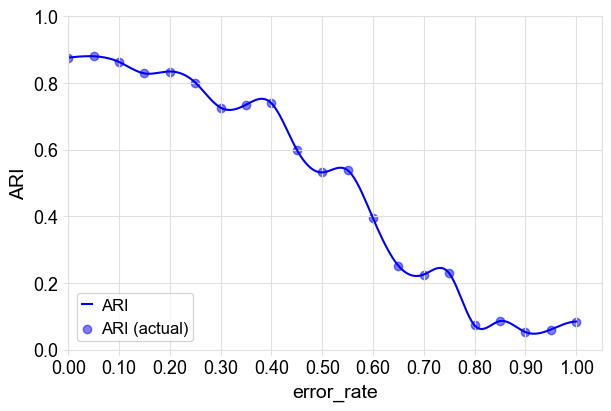

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import make_interp_spline

# 设置绘图参数
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.size"] = 14

# 读取数据
df = pd.read_csv("Enhanced_results2.tsv", sep='\t')

# 提取错误率和 ARI 数据
error_rates = df['error_rate'].values
ari = df['ARI'].values

# 生成平滑曲线
x = error_rates
y = ari
x_smooth = np.linspace(x.min(), x.max(), 200)
y_smooth = make_interp_spline(x, y)(x_smooth)

# 绘图
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)  # 调整图形大小

# 绘制平滑曲线
ax.plot(x_smooth, y_smooth, label="ARI", c='blue')

# 绘制散点图
ax.scatter(x, y, color='blue', alpha=0.5, label="ARI (actual)")

# 设置y轴刻度和标签
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.set_yticklabels(["{:.1f}".format(s) for s in np.arange(0, 1.1, 0.2)], fontsize=13)

# 设置x轴刻度和标签
ax.set_xticks(np.arange(0, 1.05, 0.1))  # 减少X轴刻度数量
ax.set_xticklabels(["{:.2f}".format(s) for s in np.arange(0, 1.05, 0.1)], fontsize=13)
ax.set_xlim(0, 1.05)
ax.set_ylim(0, 1)

# 设置标签
ax.set_xlabel("error_rate")
ax.set_ylabel("ARI")

# 添加图例
ax.legend(fontsize=12, handletextpad=0.5, loc="lower left",
          borderpad=0.3,
          columnspacing=1.3,
          handlelength=0.65)

# 添加网格线
ax.yaxis.grid(True, color='#e0e0e0')
ax.xaxis.grid(True, color='#e0e0e0')

# 设置坐标轴颜色
ax.spines['top'].set_edgecolor('#e0e0e0')
ax.spines['bottom'].set_edgecolor('#e0e0e0')
ax.spines['left'].set_edgecolor('#e0e0e0')
ax.spines['right'].set_edgecolor('#e0e0e0')

# 设置刻度颜色
ax.tick_params(axis='both', color='#e0e0e0')

# 保存图像
plt.savefig("Enhanced_results2.svg")
plt.show()

### 结果分析：
 1. 从打印的具体数值和绘制的ARI图中我们可以看出，使用多个分类器结合的方式来对数据集中的细胞进行分类的方法，在错误率较低的情况下，提升了模型的性能，例如当错误率为0时，最终的ARI值可以达到0.8763，这是基础算法中无法达到的；另外，在错误率较低的情况下，新算法的ARI值均明显高于基础算法的结果，因此我们可以认定在低错误率情况下，新算法具有更好的性能；但同样地，结合图示可以看出，新算法所绘制出的图的下降幅度更大，下降速率更快，尤其是在高错误率的情况下，其ARI值几乎接近于零。
 2. 这说明新算法由于结合了多个分类器，它在处理干净数据时能够更好地捕捉数据的内在结构，实现分类性能的提升；但同样因为其依赖于多个分类器的组合，这些分类器在面对大量错误标签时无法有效地区分噪声和真实信号，从而导致了在高错误率情况下的性能下降；而对于基础算法，虽然其在高错误率下性能也并不理想，但其下降速度更慢，这表明基础算法对于错误标签的适应能力更强，即使在高噪声的环境下也能保持一定的分类性能。
 3. 最后针对算法的准确性和鲁棒性进行分析：在错误率为0时ARI的值为0.8763；在错误率<=0.40的情况下，ARI的值仍然大于0.7，这表明算法在低错误率下具有较高的准确性，并且在错误率不超过40%时仍能保持较好性能

### 我们也实现了单独使用支持向量机算法来处理原始数据集
 - 这里我们选择使用支持向量机(SVC)来实现，同时引入标签修正的思想.我们训练了一个SVC模型以学习细胞数据的特征与标签之间的映射关系，使用训练好的模型来预测整个数据集的标签并基于SVC的预测概率来评估每个样本的置信度,进而判断是否需要对其进行修正.

In [22]:
import numpy as np
import pandas as pd
import random
import time
import scanpy as sc
from sklearn.svm import SVC
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, StratifiedKFold

# ------------------------------
# 1. 数据预处理部分
# ------------------------------
def preprocess_adata(adata):
    """
    对单细胞数据执行插补、降维、特征选择等标准流程，返回预处理后的AnnData
    """
    import magic
    magic_op = magic.MAGIC()
    adata.X = magic_op.fit_transform(adata.X)

    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, min_disp=0.5)
    adata = adata[:, adata.var.highly_variable]

    sc.pp.scale(adata)
    sc.tl.pca(adata, n_comps=50)
    return adata


def encode_labels(adata):
    """
    将原始标签编码为数值并返回编码结果，适用于多分类
    """
    labels = adata.obs['annotation'].values
    unique_labels = np.unique(labels)
    val_map = {lbl: i for i, lbl in enumerate(unique_labels)}
    encoded = np.array([val_map[lbl] for lbl in labels])
    return encoded, val_map


# ------------------------------
# 2. 引入错误标签
# ------------------------------
def introduce_errors(y_train, error_rate):
    """
    在训练标签中引入指定比例的错误标签
    """
    num_errors = int(len(y_train) * error_rate)
    error_indices = random.sample(list(range(len(y_train))), num_errors)
    unique_labels = np.unique(y_train)
    for idx in error_indices:
        y_train[idx] = random.choice([lbl for lbl in unique_labels if lbl != y_train[idx]])
    return y_train


# ------------------------------
# 3. 训练并预测
# ------------------------------
def train_and_predict(X_train, y_train, X_all):
    """
    使用支持向量机进行训练并进行预测，返回预测结果
    """
    clf = SVC(kernel='rbf', probability=True, random_state=42)
    clf.fit(X_train, y_train)
    final_pred = clf.predict(X_all)
    return final_pred


# ------------------------------
# 4. 基于验证集和置信度的修正
# ------------------------------
def correct_labels_with_validation(X_train, y_train, X_val, y_val, threshold=0.75):
    """
    基于验证集和置信度修正训练标签
    """
    clf = SVC(kernel='rbf', probability=True, random_state=42)
    clf.fit(X_train, y_train)
    pred_proba_train = clf.predict_proba(X_train)
    pred_proba_val = clf.predict_proba(X_val)
    pred_val = clf.predict(X_val)

    y_train_corrected = y_train.copy()
    for i in range(len(y_train)):
        max_proba_train = max(pred_proba_train[i])
        max_idx_train = np.argmax(pred_proba_train[i])

        # 找到验证集中与训练集相同聚类的索引
        val_indices = np.where(np.argmax(pred_proba_val, axis=1) == max_idx_train)[0]
        if len(val_indices) > 0:
            val_pred_probas = pred_proba_val[val_indices]
            val_max_probas = np.max(val_pred_probas, axis=1)
            val_max_idx = np.argmax(val_pred_probas, axis=1)

            # 计算验证集中最大概率的平均值
            avg_max_proba_val = np.mean(val_max_probas)
            if max_proba_train >= threshold and avg_max_proba_val >= threshold:
                y_train_corrected[i] = max_idx_train

    return y_train_corrected


# ------------------------------
# 5. 主流程
# ------------------------------
def main():
    df = pd.DataFrame(columns=['Error Rate', 'ARI_o', 'ARI_r', 'Time'])
    overall_start = time.time()

    # 读数据 & 预处理
    adata = sc.read('dataset.h5ad')
    adata = preprocess_adata(adata)

    # 特征(PCA 50维)
    X_features = adata.obsm['X_pca']
    encoded_labels, val_map = encode_labels(adata)
    n_classes = len(val_map)

    # 错误率范围
    error_rates = np.arange(0, 0.96, 0.05)

    # 交叉验证设置
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for er in error_rates:
        ari_o_list = []
        ari_r_list = []
        start_loop = time.perf_counter()

        for train_index, val_index in skf.split(X_features, encoded_labels):
            X_train, X_val = X_features[train_index], X_features[val_index]
            y_train, y_val = encoded_labels[train_index], encoded_labels[val_index]

            # 屏蔽90%的正常标签
            labeled_indices = random.sample(list(range(len(y_train))), int(len(y_train) * 0.1))
            X_train_labeled = X_train[labeled_indices]
            y_train_labeled = y_train[labeled_indices]

            # 引入错误标签（根据当前错误率）
            y_train_labeled = introduce_errors(y_train_labeled, er)

            # 训练并预测（标签修正前）
            pred_classify_o = train_and_predict(X_train_labeled, y_train_labeled, X_features)
            ari_o = adjusted_rand_score(encoded_labels, pred_classify_o)
            ari_o_list.append(ari_o)

            # 基于验证集和置信度修正标签
            y_train_corrected = correct_labels_with_validation(X_train_labeled, y_train_labeled, X_val, y_val, threshold=0.75)

            # 训练并预测（标签修正后）
            pred_classify_r = train_and_predict(X_train_labeled, y_train_corrected, X_features)
            ari_r = adjusted_rand_score(encoded_labels, pred_classify_r)
            ari_r_list.append(ari_r)

        end_loop = time.perf_counter()
        loop_time = end_loop - start_loop

        # 计算平均ARI值
        avg_ari_o = np.mean(ari_o_list)
        avg_ari_r = np.mean(ari_r_list)

        df.loc[len(df)] = [er, avg_ari_o, avg_ari_r, round(loop_time, 4)]
        print(f"Error Rate={er:.2f}, ARI_o={avg_ari_o:.4f}, ARI_r={avg_ari_r:.4f}, Time={loop_time:.2f}")

    # 保存结果
    df.to_csv("Enhanced_results.tsv", sep='\t', index=False)
    print("All done. Total elapsed:", time.time() - overall_start)


if __name__ == "__main__":
    main()

Calculating MAGIC...
  Running MAGIC on 3000 cells and 2000 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


C:\Users\20605\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\20605\AppData\Local\Programs\Python\Python312\Lib\site-packages\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 0.68 seconds.
    Calculating KNN search...
    Calculated KNN search in 1.19 seconds.
    Calculating affinities...


C:\Users\20605\AppData\Local\Programs\Python\Python312\Lib\site-packages\graphtools\graphs.py:290: RuntimeWarning: Detected zero distance between 726 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 1.18 seconds.
  Calculated graph and diffusion operator in 3.05 seconds.
  Calculating imputation...
  Calculated imputation in 0.36 seconds.
Calculated MAGIC in 3.42 seconds.


C:\Users\20605\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\20605\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Error Rate=0.00, ARI_o=0.8240, ARI_r=0.8254, Time=1.31
Error Rate=0.05, ARI_o=0.8317, ARI_r=0.8330, Time=1.42
Error Rate=0.10, ARI_o=0.8242, ARI_r=0.8229, Time=1.42
Error Rate=0.15, ARI_o=0.8189, ARI_r=0.8189, Time=1.75
Error Rate=0.20, ARI_o=0.8024, ARI_r=0.8024, Time=1.78
Error Rate=0.25, ARI_o=0.7941, ARI_r=0.7941, Time=2.04
Error Rate=0.30, ARI_o=0.7942, ARI_r=0.7942, Time=2.20
Error Rate=0.35, ARI_o=0.7742, ARI_r=0.7742, Time=1.99
Error Rate=0.40, ARI_o=0.7610, ARI_r=0.7610, Time=2.00
Error Rate=0.45, ARI_o=0.7532, ARI_r=0.7532, Time=2.07
Error Rate=0.50, ARI_o=0.7229, ARI_r=0.7229, Time=2.38
Error Rate=0.55, ARI_o=0.7282, ARI_r=0.7282, Time=2.57
Error Rate=0.60, ARI_o=0.6323, ARI_r=0.6323, Time=2.39
Error Rate=0.65, ARI_o=0.6579, ARI_r=0.6579, Time=2.50
Error Rate=0.70, ARI_o=0.5303, ARI_r=0.5303, Time=2.50
Error Rate=0.75, ARI_o=0.5285, ARI_r=0.5285, Time=2.49
Error Rate=0.80, ARI_o=0.4362, ARI_r=0.4362, Time=2.50
Error Rate=0.85, ARI_o=0.3741, ARI_r=0.3741, Time=2.14
Error Rate


1. 数据预处理部分：preprocess_adata方法用于对数据进行预处理，这里我们使用了插补、归一化、对数变换、特征选择以及降维这几个方法来实现；encode_labels方法则对原始标签进行编码，将其编码为数值标签.
2. 引入错误标签：根据要求，在预测过程中需要屏蔽90%正常标签并模拟10%错误标签，因此在这里我们通过introduce_errors方法来在训练标签中随机引入错误标签.
3. 模型训练：这里我们采用了支持向量机(SVC)来进行训练并预测.
4. 标签修正：在方法correct_labels_with_validation中，我们实现了基于验证集和置信度的修正，当训练集中某个样本的最大预测概率大于阈值时，我们修正该标签。
5. 主函数：在主函数中，我们设置错误率从0到0.95，以0.05为步长，并且引入了交叉验证(5折交叉验证)，在每次迭代过程中，都会随机选择10%的训练数据作为已标记数据，进一步地我们引入错误标签，训练模型后计算修正前的ARI值-ARI_o，然后我们对标签进行修正，再次计算修正后的ARI值-ARI_r,最终将每个错误率下的平均ARI值保存下来.

### 结果可视化

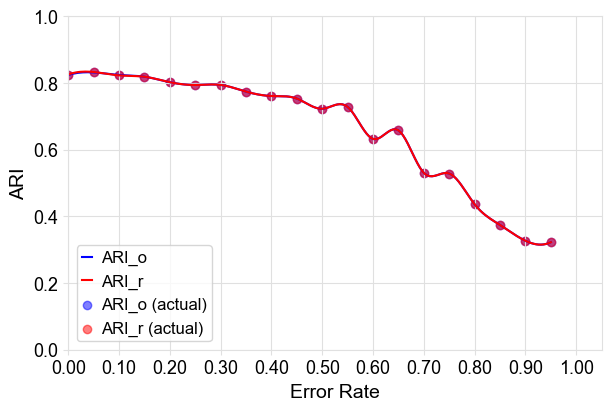

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import make_interp_spline

# 设置绘图参数
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.size"] = 14

# 读取数据
df = pd.read_csv("Enhanced_results.tsv", sep='\t')

# 提取错误率、ARI_o 和 ARI_r
error_rates = df['Error Rate'].values
ari_o = df['ARI_o'].values
ari_r = df['ARI_r'].values

# 生成平滑曲线
x = error_rates
y_o = ari_o
y_r = ari_r
x_smooth = np.linspace(x.min(), x.max(), 200)
y_smooth_o = make_interp_spline(x, y_o)(x_smooth)
y_smooth_r = make_interp_spline(x, y_r)(x_smooth)

# 绘图
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)  # 调整图形大小

# 绘制平滑曲线
l_o = ax.plot(x_smooth, y_smooth_o, label="ARI_o", c='blue')
l_r = ax.plot(x_smooth, y_smooth_r, label="ARI_r", c='red')

# 绘制散点图
ax.scatter(x, y_o, color='blue', alpha=0.5, label="ARI_o (actual)")
ax.scatter(x, y_r, color='red', alpha=0.5, label="ARI_r (actual)")

# 设置y轴刻度和标签
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.set_yticklabels(["{:.1f}".format(s) for s in np.arange(0, 1.1, 0.2)], fontsize=13)

# 设置x轴刻度和标签
ax.set_xticks(np.arange(0, 1.05, 0.1))  # 减少X轴刻度数量
ax.set_xticklabels(["{:.2f}".format(s) for s in np.arange(0, 1.05, 0.1)], fontsize=13)
ax.set_xlim(0, 1.05)
ax.set_ylim(0, 1)

# 设置标签
ax.set_xlabel("Error Rate")
ax.set_ylabel("ARI")

# 添加图例
ax.legend(fontsize=12, handletextpad=0.5, loc="lower left",
          borderpad=0.3,
          columnspacing=1.3,
          handlelength=0.65)

# 添加网格线
ax.yaxis.grid(True, color='#e0e0e0')
ax.xaxis.grid(True, color='#e0e0e0')

# 设置坐标轴颜色
ax.spines['top'].set_edgecolor('#e0e0e0')
ax.spines['bottom'].set_edgecolor('#e0e0e0')
ax.spines['left'].set_edgecolor('#e0e0e0')
ax.spines['right'].set_edgecolor('#e0e0e0')

# 设置刻度颜色
ax.tick_params(axis='both', color='#e0e0e0')

# 保存图像
plt.savefig("Enhanced_results.svg")
plt.show()

### 结果分析：
1. 从输出的结果和绘制的ARI图可以看出，单独使用支持向量机对细胞数据集进行预测，得到的分类效果实际上和基础要求中实现的算法性能相似；但也可以明显看出当错误提升到一个较高的水平时，使用SVC得到的预测结果（根据ARI值来判断）明显要由于基础要求中实现的算法的性能；除此之外，也可看出使用SVC模型得出的不同错误率下的ARI曲线，其下降速度是要更快的。
2. 结合以上分析，我们认为，在高错误率下SVC模型会表现出更好的鲁棒性，但其对噪声更加敏感，而基础算法虽然高错误率下表现较差，但在低错误率下有着更好的表现，且对噪声的适应能力更强。
3. 最后针对算法的准确性和鲁棒性进行分析：在错误率为0时ARI的值为0.8254；在错误率<=0.55的情况下，ARI的值仍然大于0.7，这表明算法在低错误率下具有较高的准确性，并且在错误率不超过55%时仍能保持较好性能